In [33]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
import os

Keras modelleri 3 tip girdiyi kabul etmektedir:
1. NumPy dizileri
2. TensorFlow Dataset objeleri
3. Python generator fonksiyonları

Eğer eldeki verinin boyutu büyükse veya GPU(lar) üzerinde işlem yapılacaksa Dataset objeleri kullanmak daha yüksek performans sağlayacaktır.

**tf.keras.preprocessing.image_dataset_from_directory** fonksiyonu ile çok sayıda alt dosya içinde sınıflandırılmış resim dosyaları Dataset objesine dönüştürülür.

In [2]:
# Dataset objesi yaratma
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "data",
    shuffle=True,
    image_size=(256,256),
    batch_size=(32)
)

Found 2156 files belonging to 3 classes.


In [3]:
data_class_names= dataset.class_names
data_class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [4]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[0 1 0 0 0 1 0 0 2 1 0 1 0 0 0 0 0 1 1 0 0 0 1 1 1 0 1 0 0 1 0 2]


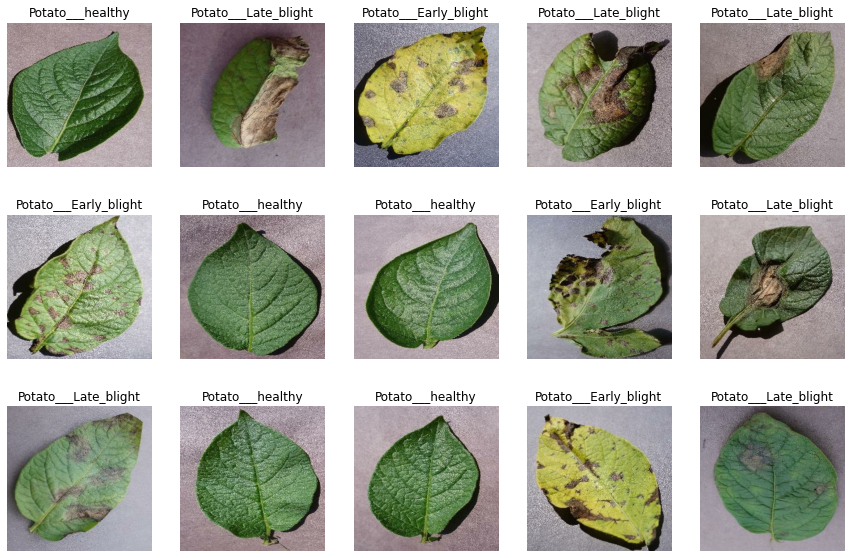

In [5]:
# Veri Görselleştirme

plt.figure(figsize=(15,10))

for image_batch, label_batch in dataset.take(1):
    for i in range(15): 
        ax= plt.subplot(3,5,i+1) 
        # image_batch tensor türünde bunu numpy türüne dönüştürüyoruz.
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(data_class_names[label_batch[i]])
        plt.axis("off")

Veri setinin %80 'ni eğitim ve kalan %20 sinin de %10 unu validation yani doğrulama, kalan %10 test verisi olacak şekilde ayırıyoruz.
 * 80% training 
 * 10% validation
 * 10% test

In [6]:
len(dataset)

68

In [7]:
len(dataset)*0.8

54.400000000000006

In [8]:
train_dataset= dataset.take(54)
len(train_dataset)

54

In [10]:
test_dataset= dataset.skip(54)
len(test_dataset)

14

In [11]:
# validation
len(dataset)*0.1

6.800000000000001

In [13]:
val_dataset= test_dataset.take(6)
test_dataset= test_dataset.skip(6)
print(len(val_dataset))
print(len(test_dataset))

6
8


In [14]:
# Yapılan bu işlem adımlarını bir fonksiyonda toplayalım

def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000): 
    
    ds_size= len(ds)
    
    if shuffle: 
        ds=ds.shuffle(shuffle_size,seed=12)
#seed sadece tahmin edilebilirlik için yani aynı verileri vermemek için kullanılır.

    train_size= int(train_split*ds_size)
    val_size= int(val_split*ds_size)

    train_data= ds.take(train_size)
    val_data= ds.skip(train_size).take(val_size)
    test_data= ds.skip(train_size).skip(val_size)
    
    return train_data, val_data, test_data

In [15]:
train_data, val_data, test_data= get_dataset_partitions_tf(dataset)

In [16]:
print("train data:", len(train_data))
print("validation data:", len(val_data))
print("test data:", len(test_data))

train data: 54
validation data: 6
test data: 8


In [17]:
train_data = train_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_data = val_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_data = test_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

Burada zaman harcamamak için veriler ön belleğe alınır. **Prefetch** ile verileri kullanılacağı zaman değil de daha önceden getirilmesi sağlanır.

* Önbellek (**Cache**), verilerin daha hızlı yüklenmesine yardımcı olmayı sağlayan depolama alanıdır. Veri aktarımı sırasında hafızadan getirilen verilerin, işlemci hızını yakalayamaması sebebiyle veri aktarımı yavaşlar. Önbellek sayesinde gelen veriler ön belleğe alınır ve daha hızlı bir erişim sağlanır. Özellikle tekrarlanan verilerin ön bellekte tutulması hızı artırır.

### Ön İşleme İçin Katman Oluşturma

In [18]:
resize_and_rescale= tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(256, 256),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [19]:
# Veri Çoğaltma

data_augementation= tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"), # yatay ve dikey olarak rastgele çevirir.
    layers.experimental.preprocessing.RandomRotation(0.2), # rastgele döndürme
])

### Model Oluşturma

In [20]:
n_classes=3

model= models.Sequential([
    
    resize_and_rescale,
    data_augementation, 
    
    layers.Conv2D(32, kernel_size=(3,3), activation ="relu", input_shape=(32,256,256,3)),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(64, kernel_size=(3,3), activation ="relu"),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(64, kernel_size=(3,3), activation ="relu"),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(64, (3,3), activation ="relu"),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(64, kernel_size=(3,3), activation ="relu"),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(64, kernel_size=(3,3), activation ="relu"),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),
    
    layers.Dense(64, activation="relu"),
    layers.Dense(n_classes, activation ="softmax"), 
])
model.build((32,256,256,3))

Resme filtre uyguladıktan sonra elde ettiğimiz çıktıya relu altivasyon fonksiyonunu uygulayarak eksili değerleri sıfırlayıp pozitif verilerle özellikleri belirtmeye devam ediyoruz. Daha sonra MaxPooling uygulayarak 2x2 lik ızgaralar içerisinde en büyük sayıları seçip hem resim boyutunda küçültme hemde daha iyi özellik seçme belirtme sağlıyoruz. Havuzlama boyutu ve işlem yükünü azaltır. Aynı zamanda overfitting(aşırı öğrenme) problemini çözmek için de kullanılır.

In [21]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [22]:
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
    metrics=["accuracy"]
)

Ağın derlenmesi için Sequential sınıfının **“compile”** metodu kullanılmaktadır. Modeli eğitim için yapılandırır.

* **“optimizer”** parametresi, w değerlerinin iyileştirilmesi için kullanılan optimizasyon algoritmalarının kullanılmasını sağlamaktadır. Kullanılan **“adam”** (Adaptive Moment Estimation) algoritması, her bir parametre için gerçek zamanlı olarak öğrenme oranını günceller. Bir gradient descent yöntemidir.


* **“loss”** parametresi, her eğitimden sonra elde edilen değerler ile gerçek değerler arasındaki hata farkının hesaplanmasıdır. İki veya daha fazla sınıfınız varsa ve etiketler tamsayıysa, **“SparseCategoricalCrossentropy”** kullanılmalıdır. Etiketler ve tahminler arasındaki çapraz entropi kaybını hesaplar.


* **“metrics”** parametresi, eğitim aşamasında her epoch sonrasında sonuçları değerlendirmek için bir sınanma işlemi yapmaktadır. Kullanılan **“accuracy”**, modelin başarısını inceleyebilmek için kullanılan yaygın bir metriktir.

In [23]:
history = model.fit(
    train_data,
    epochs= 50,
    batch_size=32,
    verbose=1,
    validation_data= val_data
)

Epoch 1/50
54/54 [==============================] - 55s 978ms/step - loss: 0.9196 - accuracy: 0.4873 - val_loss: 0.9351 - val_accuracy: 0.3646
Epoch 2/50
54/54 [==============================] - 54s 992ms/step - loss: 0.7938 - accuracy: 0.5926 - val_loss: 0.7245 - val_accuracy: 0.6042
Epoch 3/50
54/54 [==============================] - 54s 1s/step - loss: 0.5439 - accuracy: 0.7407 - val_loss: 0.4571 - val_accuracy: 0.7917
Epoch 4/50
54/54 [==============================] - 55s 1s/step - loss: 0.3693 - accuracy: 0.8461 - val_loss: 0.2734 - val_accuracy: 0.9167
Epoch 5/50
54/54 [==============================] - 55s 1s/step - loss: 0.2665 - accuracy: 0.8895 - val_loss: 0.2265 - val_accuracy: 0.9115
Epoch 6/50
54/54 [==============================] - 57s 1s/step - loss: 0.2215 - accuracy: 0.9149 - val_loss: 0.1193 - val_accuracy: 0.9479
Epoch 7/50
54/54 [==============================] - 57s 1s/step - loss: 0.1807 - accuracy: 0.9294 - val_loss: 0.1681 - val_accuracy: 0.9531
Epoch 8/50
54/

* **“batch_size”** eğitim veya test sırasında girdi bilgilerinin tek tek değil bir grup halinde eğitime sokulmasını sağlamaktadır. 
* **“epochs”** veri setinin modele kaç kez gireceğini belirtmek için kullanılmaktadır. 

In [24]:
# Modeli test etme
scores= model.evaluate(test_data)
scores

8/8 [==============================] - 3s 212ms/step - loss: 0.0430 - accuracy: 0.9844


[0.04301732778549194, 0.984375]

In [25]:
# ilk 5 epoch için loss değerlerindeki değişim
history.history['loss'][:5]

[0.9195687174797058,
 0.7937721014022827,
 0.5438925623893738,
 0.36929771304130554,
 0.2664679288864136]

### Çıktıları grafik üzerinde gözlemleyelim.

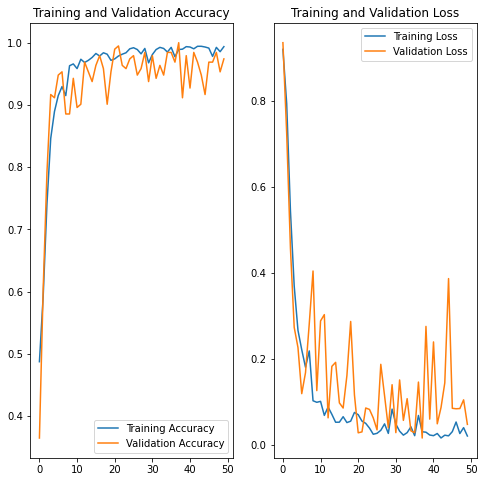

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))

plt.subplot(1, 2, 1)
plt.plot(range(50), acc, label='Training Accuracy')
plt.plot(range(50), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(50), loss, label='Training Loss')
plt.plot(range(50), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

* Başlangıçta kaybın yüksek olduğunu görebiliyoruz.

In [27]:
def predict(model, img):
    # Bu iki satırda görüntüyü numpy dizisine çevirip yığınlıyoruz.
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)
    # Expand_dims(), giriş Tensörüne bir ek boyut eklemek için kullanılır. (giriş tensörü, boyutun eklenmesi gereken dizin)
    # Örneğin 2 boyutlu bir tensoru 3 boyutlu hale getirir.
    predictions = model.predict(img_array)
    predicted_class = data_class_names[np.argmax(predictions[0])] 
    # tahmin edilen değer softmaxden dolayı 3 olasılıksal değer verir.
    # argmax ile bu değerlerden en büyük olanının indeksini alıp daha sonrada dahil olduğu sınıf ismini buluyoruz.
    confidence = round(100 * (np.max(predictions[0])), 2)
    
    return predicted_class, confidence

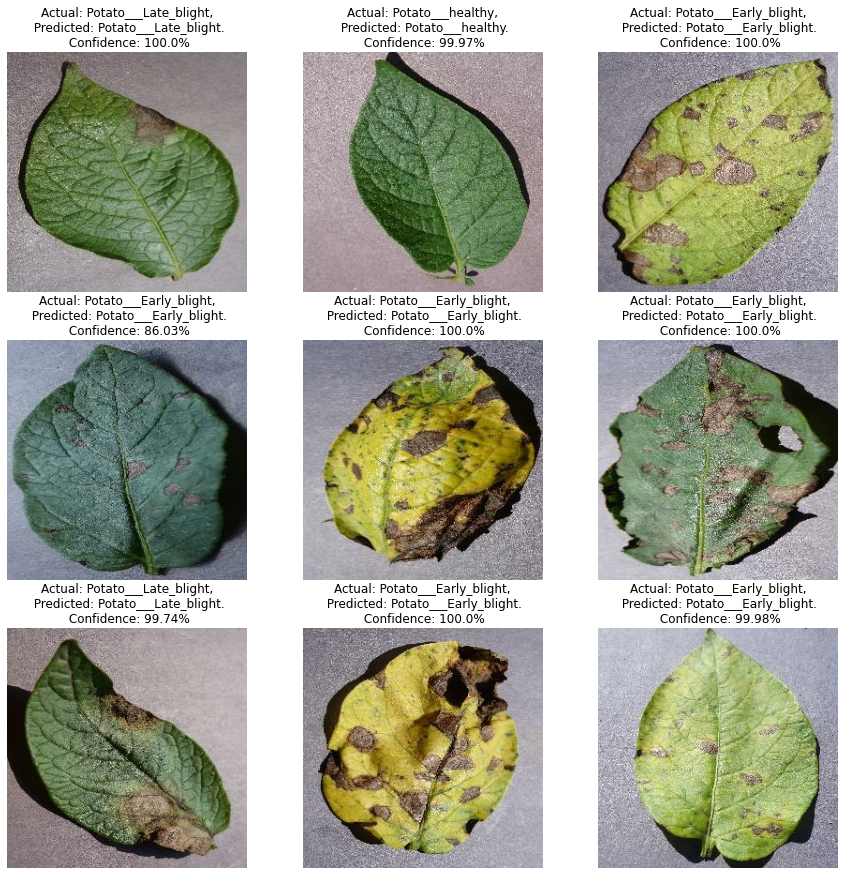

In [31]:
plt.figure(figsize=(15, 15))

for images, labels in test_data.take(1):
    for i in range(9):
        
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = data_class_names [labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

### Model Kaydetme

In [36]:
model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/1\assets
